# Reduced Rank SVD Plots

In [1]:
import time
import numpy as np
import torch
from scipy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

from side_info_decoding.utils import (
    set_seed, 
    load_data_from_pids, 
    sliding_window_over_trials
)
from side_info_decoding.reduced_rank import (
    Multi_Task_Reduced_Rank_Model, 
    train_multi_task, 
    model_eval
)

seed = 666
set_seed(seed)

/home/berk/anaconda3/envs/decoding/lib/python3.10/site-packages/ibllib/atlas/__init__.py:202: DeprecationWarning: ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use this module instead
  warnings.warn('ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use '


In [2]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 10
BIGGER_SIZE = 15
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=2)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 10

In [3]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    # "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    # "523f8301-4f56-4faf-ab33-a9ff11331118",
    # "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    # '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    # '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    # '16799c7a-e395-435d-a4c4-a678007e1550',
    # '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    # '1e176f17-d00f-49bb-87ff-26d237b525f1',
    # '31f3e083-a324-4b88-b0a4-7788ec37b191'
]

regions = ['po', 'lp', 'dg', 'ca1', 'vis']
# regions = ['alv', 'ca1', 'cing', 'dg-mo', 'dg-po', 'dg-sg', 'eth', 'fp', 'lp', 'ml', 'or', 'po', 'th', 'visam5', 'visam6a', 'vplpc']

rank = 4 # rank
d = 0 # half window size
n_epochs = 7000
n_folds = 5
n_t_bins = 40
t_before = .5
t_after = 1.5

## Training

In [4]:
all_svd_V = []
for re_idx, re in enumerate(regions):
    try:
        X_dict, Y_dict = load_data_from_pids(
            pids,
            brain_region=re,
            behavior="choice",
            data_type="all_ks",
            n_t_bins=n_t_bins,
            t_before=t_before,
            t_after=t_after,
            normalize_input=True
        )
        print(X_dict)
        print(Y_dict)
        break
    except:
        print(f"failed to load region {re}")
        continue

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

    n_units = []
    train_X_dict, test_X_dict, train_Y_dict, test_Y_dict = {}, {}, {}, {}
    for pid in pids:
        X, Y = X_dict[pid], Y_dict[pid]
        K, C, T = X.shape
        n_units.append(C)
        X = sliding_window_over_trials(X, half_window_size=d)
        Y = sliding_window_over_trials(Y, half_window_size=d)
        X, Y = torch.tensor(X), torch.tensor(Y)
        train_X_dict.update({pid: [X[train] for train, _ in skf.split(X, Y)]})
        test_X_dict.update({pid: [X[test] for _, test in skf.split(X, Y)]})
        train_Y_dict.update({pid: [Y[train] for train, _ in skf.split(X, Y)]})
        test_Y_dict.update({pid: [Y[test] for _, test in skf.split(X, Y)]})
        
    start_time = time.time()

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

    U_per_fold, V_per_fold, metrics_per_fold = [], [], []
    for fold_idx in range(n_folds):

        print(f"start training fold {fold_idx+1} on {len(pids)} sessions ..")
        train_X_lst = [train_X_dict[pid][fold_idx] for pid in pids]
        test_X_lst = [test_X_dict[pid][fold_idx] for pid in pids]
        train_Y_lst = [train_Y_dict[pid][fold_idx] for pid in pids]
        test_Y_lst = [test_Y_dict[pid][fold_idx] for pid in pids]

        multi_task_rrm = Multi_Task_Reduced_Rank_Model(
            n_tasks=len(pids),
            n_units=n_units, 
            n_t_bins=T, 
            rank=rank, 
            half_window_size=d
        )

        # training
        rrm, train_losses = train_multi_task(
            model=multi_task_rrm,
            train_dataset=(train_X_lst, train_Y_lst),
            test_dataset=(test_X_lst, test_Y_lst),
            loss_function=torch.nn.BCELoss(),
            learning_rate=1e-3,
            weight_decay=1e-1,
            n_epochs=n_epochs,
        )

        # eval
        test_U, test_V, test_metrics, test_prob = model_eval(
            multi_task_rrm, 
            train_dataset=(train_X_lst, train_Y_lst),
            test_dataset=(test_X_lst, test_Y_lst),
            behavior="choice"
        )
        U_per_fold.append(test_U)
        V_per_fold.append(test_V)
        metrics_per_fold.append(test_metrics)

    end_time = time.time()
    print(f"time spent: {end_time - start_time: .3f} seconds")
    
    Us, Vs, metrics_dict = {}, {}, {}
    for pid_idx, pid in enumerate(pids):
        metrics_dict.update({pid: np.mean(metrics_per_fold, 0)[pid_idx]})
        Us.update({pid: [U_per_fold[fold_idx][pid_idx] for fold_idx in range(n_folds)]})
        Vs.update({pid: V_per_fold})
        
    Us_plot, Vs_plot = [], []
    for pid in pids:
        # average U and V across trials
        Us_plot.append(np.array(Us[pid]).mean(0))
        Vs_plot.append(np.array(Vs[pid]).mean(0).squeeze().T)
    u_min, u_max = np.min(np.concatenate(Us_plot)), np.max(np.concatenate(Us_plot))
    v_min, v_max = np.min(np.concatenate(Vs_plot)), np.max(np.concatenate(Vs_plot))
    c_min, c_max = np.min([u_min, v_min]), np.max([u_max, v_max])
    
    # Draw svd for all regions for each pid dataset
    svd_W, svd_U, svd_S, svd_VT, S_mul_VT, W_reduced = [], [], [], [], [], []
    for pid in pids:
        # average U and V across trials
        W = np.array(Us[pid]).mean(0) @ np.array(Vs[pid]).mean(0).squeeze()
        U, S, VT = svd(W)
        svd_W.append(W)
        svd_U.append(U[:, :rank])
        svd_S.append(S[:rank])
        svd_VT.append(VT[:rank, :])
        # W_low_rank = np.dot(np.dot(U[:, :R],np.diag(S[:R])),VT[:R, :])
        # W_reduced.append(W_low_rank)
    
    np.save(f"models/mat_U_{re}.npy", np.array(svd_U))
    np.save(f"models/mat_S_{re}.npy", np.array(svd_S))
    np.save(f"models/mat_VT_{re}.npy", np.array(svd_VT))

    #     if len(S) == 1:
    #         S_mul_VT.append(np.diag(S) @ VT[:1, :])
    #     else:
    #         S_mul_VT.append(np.diag(S[:rank]) @ VT[:rank, :])

    # all_svd_V.append(S_mul_VT)

    # S_mul_VT = np.array(S_mul_VT)
    # Save S_mul_VT to a npy file
    # np.save(f"models/S_mul_VT_{re}.npy", S_mul_VT)

all_svd_V = np.array(all_svd_V)

/home/berk/anaconda3/envs/decoding/lib/python3.10/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367 (active: 367)


brainbox.behavior.wheel.velocity has been deprecated. Use velocity_filtered instead.


File "/home/berk/anaconda3/envs/decoding/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
File "/home/berk/anaconda3/envs/decoding/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
File "/home/berk/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
File "/home/berk/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
File "/home/berk/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 728, in start
    self.io_loop.start()
File "/home/berk/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
File "/home/berk/anaconda3/envs/decoding/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
File "/home/berk/anaconda3/envs/decoding/lib/python3.10/asyncio/base_events.py", line 19

Compute spike count: 100%|██████████| 367/367 [00:00<00:00, 448.07it/s]

{'dab512bd-a02d-4c1f-8dbc-9155a163efc0': array([[[-0.49994559, -0.49994559, -0.49994559, ...,  1.49775016,
          0.165953  ,  0.83185158],
        [-0.49994559, -0.49994559, -0.49994559, ..., -0.49994559,
         -0.49994559, -0.49994559],
        [-0.49994559, -0.49994559, -0.49994559, ..., -0.49994559,
         -0.49994559, -0.49994559],
        ...,
        [-0.03823597, -0.03823597, -0.03823597, ..., -0.03823597,
         -0.03823597, -0.03823597],
        [-0.03823597, -0.03823597, -0.03823597, ..., -0.03823597,
         -0.03823597, -0.03823597],
        [-0.03823597, -0.03823597, -0.03823597, ..., -0.03823597,
         -0.03823597, -0.03823597]],

       [[-0.49994559, -0.49994559, -0.49994559, ...,  0.165953  ,
          0.83185158,  0.165953  ],
        [-0.49994559, -0.49994559, -0.49994559, ..., -0.49994559,
         -0.49994559, -0.49994559],
        [-0.49994559, -0.49994559, -0.49994559, ..., -0.49994559,
         -0.49994559, -0.49994559],
        ...,
        [-0.0

In [8]:
print(Y_dict["dab512bd-a02d-4c1f-8dbc-9155a163efc0"].shape)
X_dict["dab512bd-a02d-4c1f-8dbc-9155a163efc0"].shape

(367,)


(367, 160, 40)

In [ ]:
# load data from models/S_mul_VT_re.npy for each region re
S_mul_VT_ca1 = np.load(f"models/S_mul_VT_ca1.npy", allow_pickle=True)
S_mul_VT_dg = np.load(f"models/S_mul_VT_dg.npy", allow_pickle=True)
S_mul_VT_lp = np.load(f"models/S_mul_VT_lp.npy", allow_pickle=True)
S_mul_VT_po = np.load(f"models/S_mul_VT_po.npy", allow_pickle=True)
S_mul_VT_vis = np.load(f"models/S_mul_VT_vis.npy", allow_pickle=True)

zeros_filled = np.zeros((rank, n_t_bins))
zeros_filled[0] = S_mul_VT_vis[2][0]
S_mul_VT_vis[2] = zeros_filled
S_mul_VT_vis = np.array(S_mul_VT_vis.tolist())

all_svd_V = np.array((S_mul_VT_ca1, S_mul_VT_dg, S_mul_VT_lp, S_mul_VT_po, S_mul_VT_vis))

## Plotting

In [ ]:
print(f"all_svd_V: {all_svd_V.shape[0]} brain region, {all_svd_V.shape[1]} pids, and rank {all_svd_V.shape[2]} data from {all_svd_V.shape[3]} time bins.")

all_svd_V: 5 brain region, 10 pids, and rank 4 data from 40 time bins.


/tmp/ipykernel_190772/4176396096.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


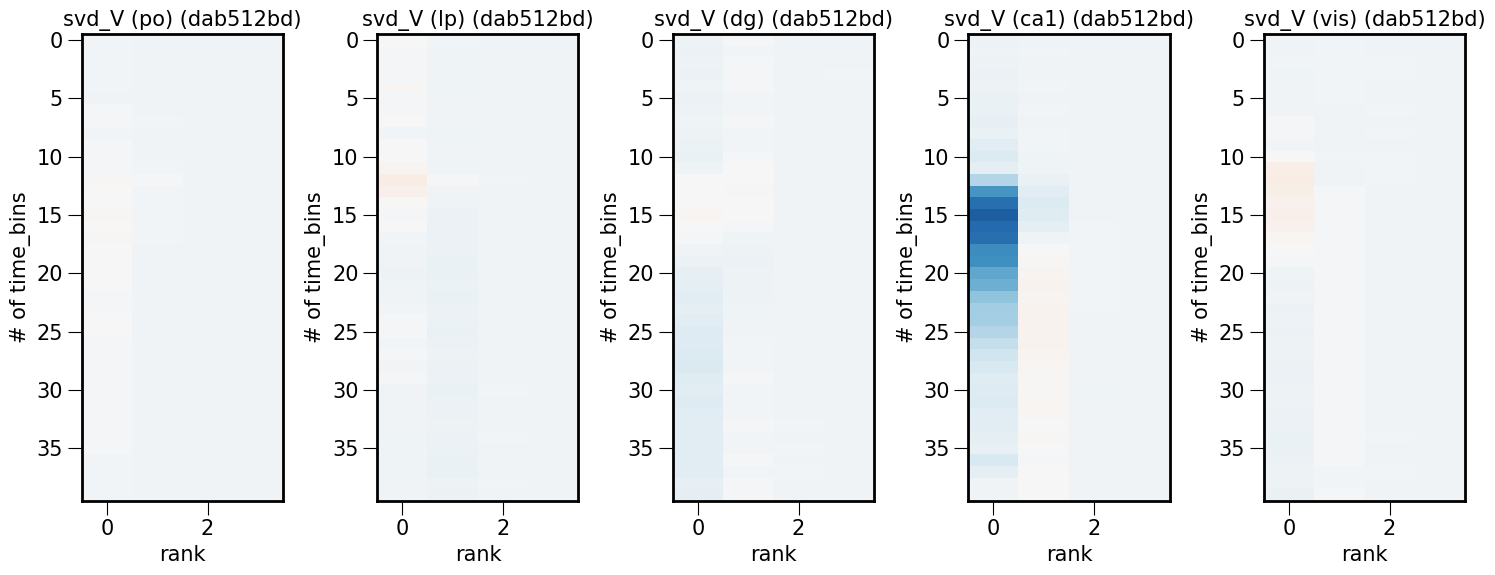

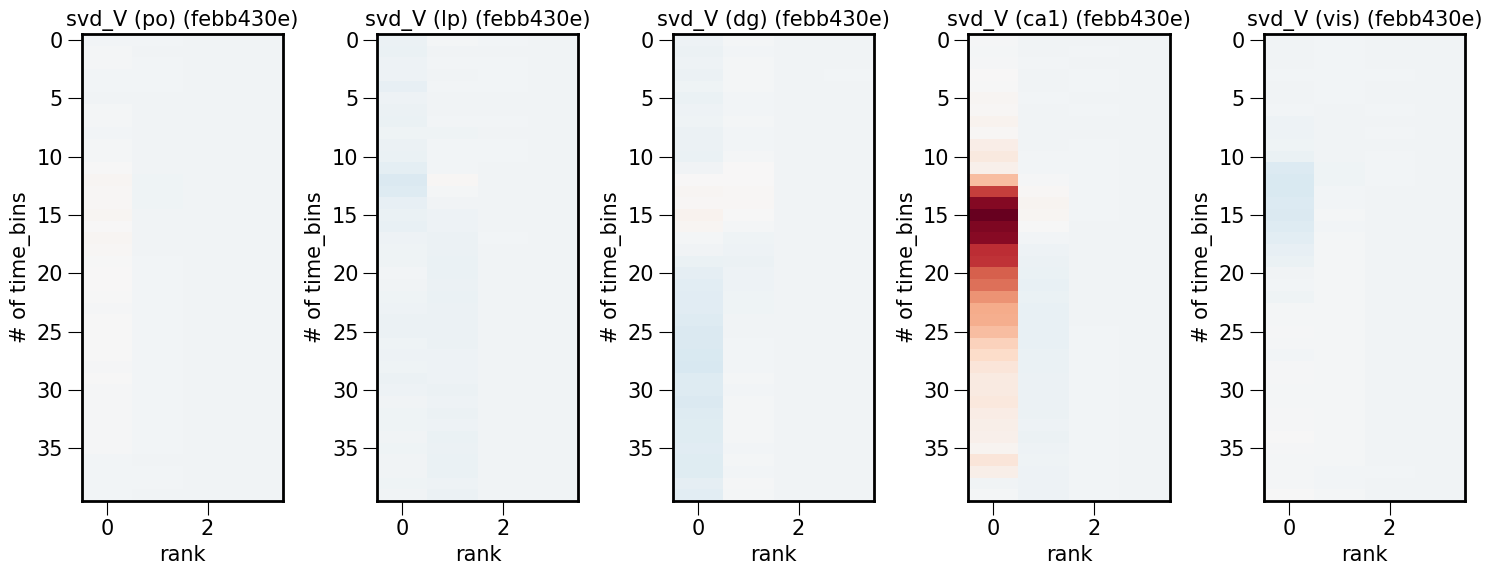

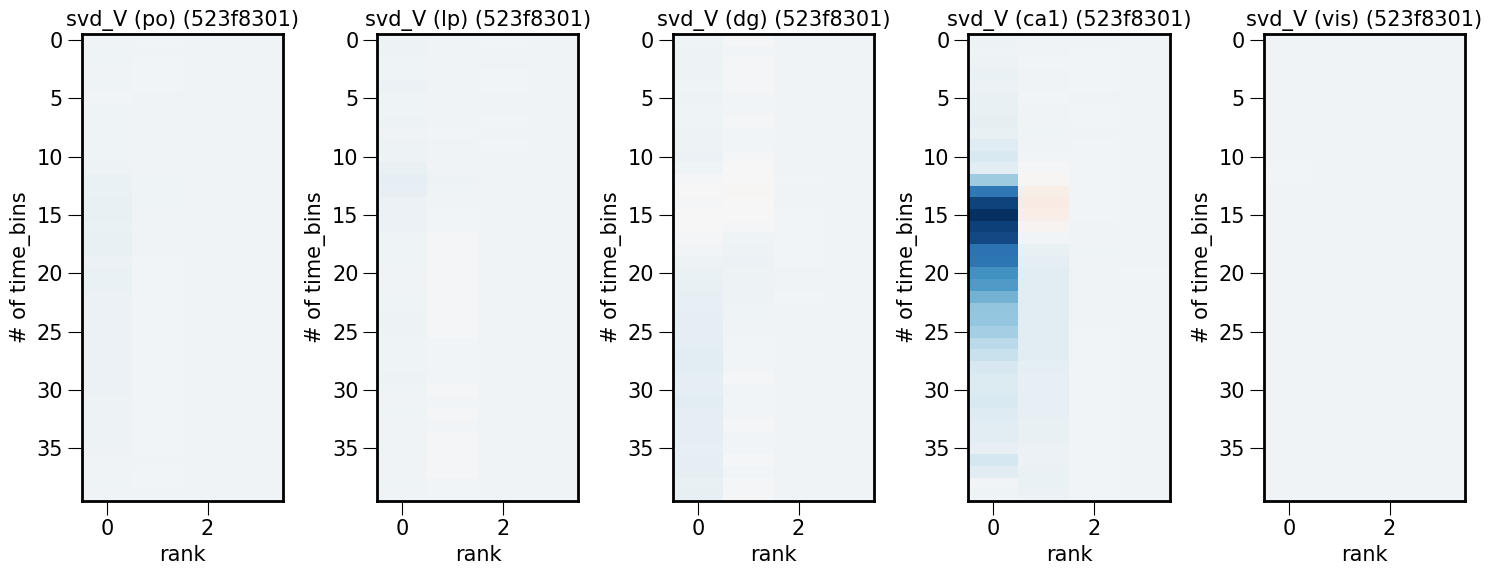

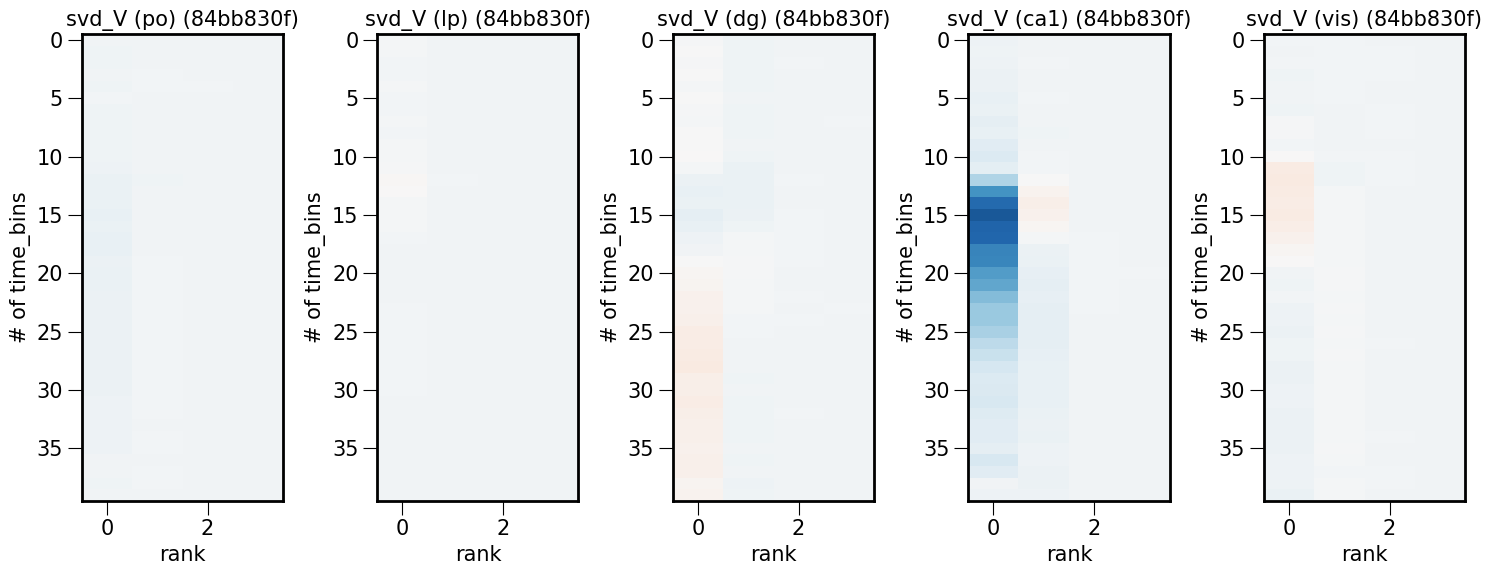

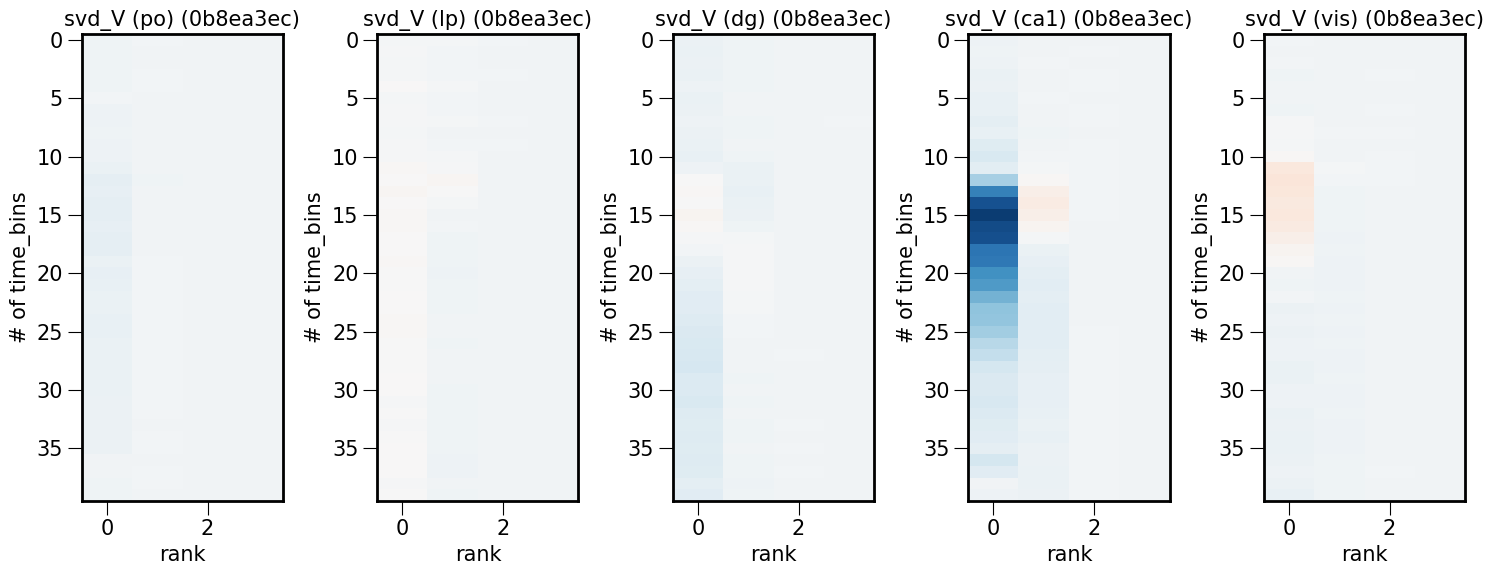

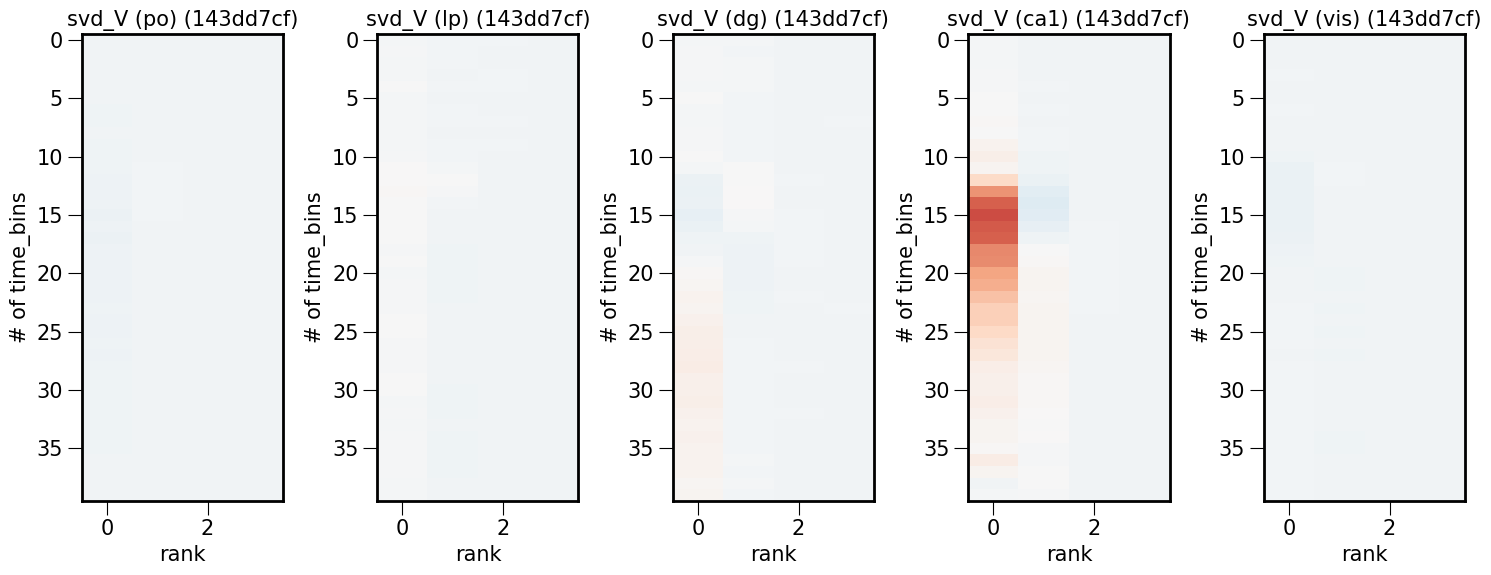

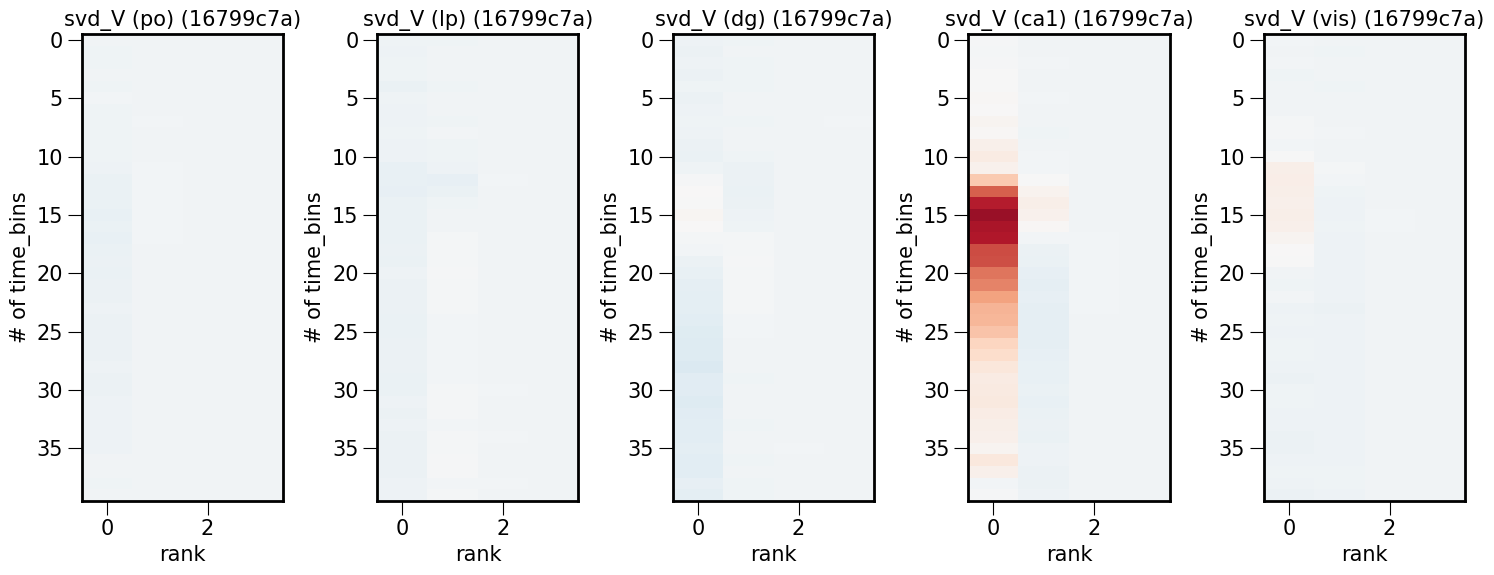

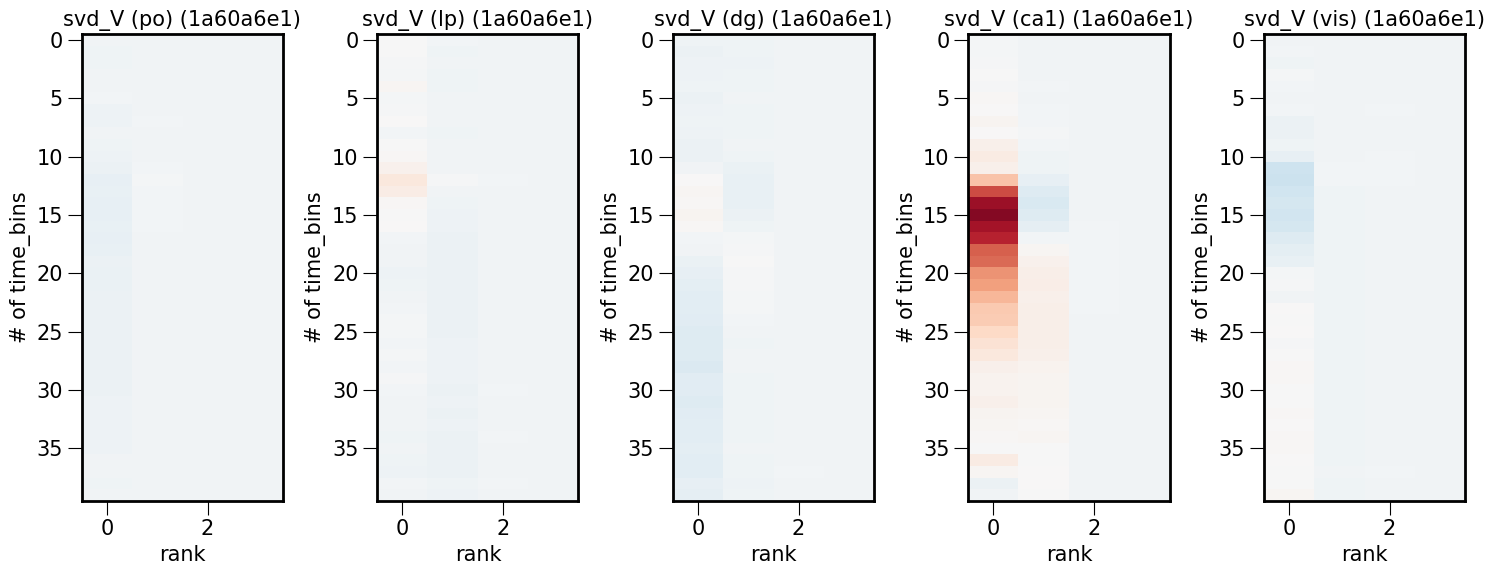

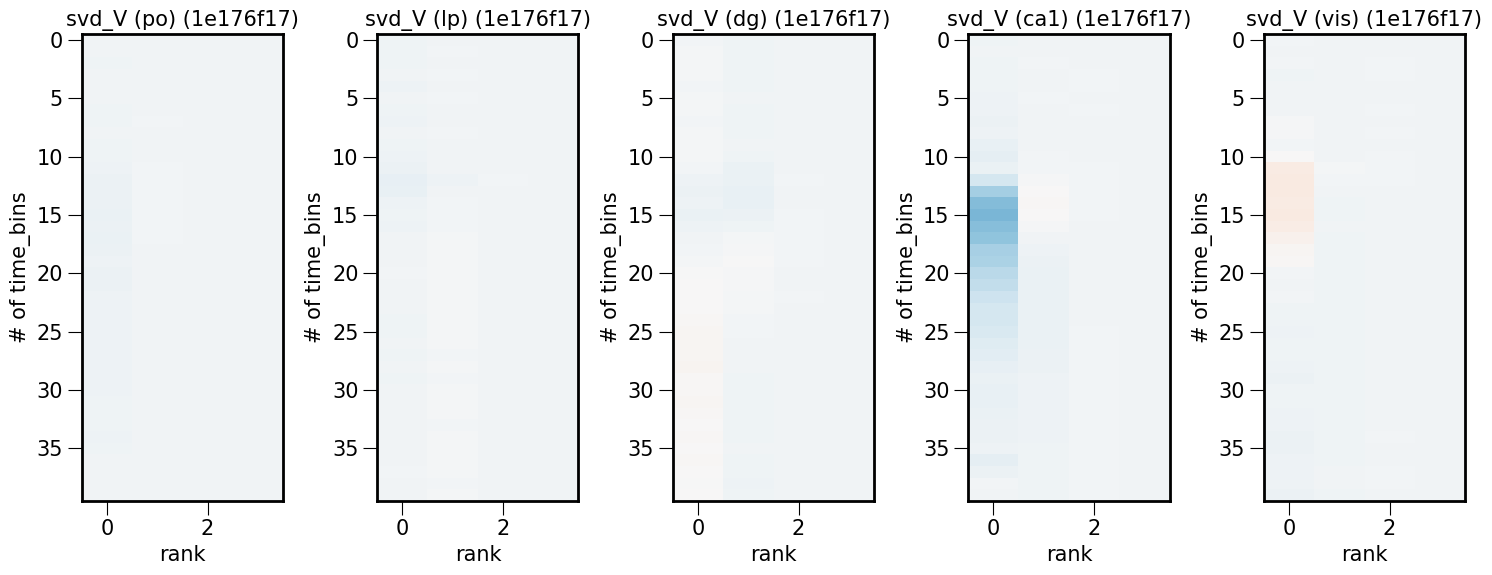

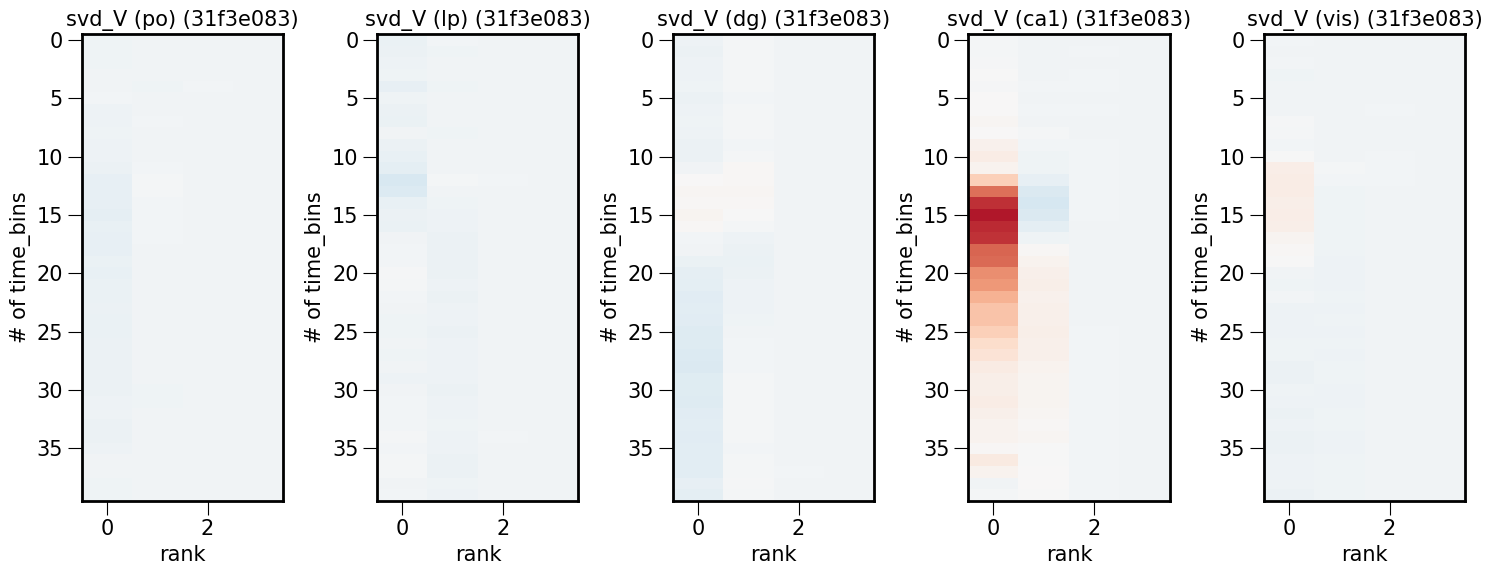

In [ ]:
v_min, v_max = np.min([arr.min() for sublist in all_svd_V for arr in sublist]), np.max([arr.max() for sublist in all_svd_V for arr in sublist])

for pid_idx, pid in enumerate(pids):
    fig, axes = plt.subplots(1, 5, figsize=(15, 6))
    for re_idx, re in enumerate(regions):

        heatmap1 = axes[re_idx].imshow(all_svd_V[re_idx][pid_idx].T, aspect="auto", cmap="RdBu_r", vmin=v_min, vmax=v_max)
        # cbar = fig.colorbar(heatmap1, ax=ax1, shrink=1)
        axes[re_idx].set_title(re)

        axes[re_idx].set_ylabel("# of time_bins")
        axes[re_idx].set_xlabel("rank")
        axes[re_idx].set_title(f"svd_V ({re}) ({pid[:8]})")
        plt.tight_layout()
        filename = f"./figures/plot_{pid_idx+1}.png"
        fig.savefig(filename, dpi=100)


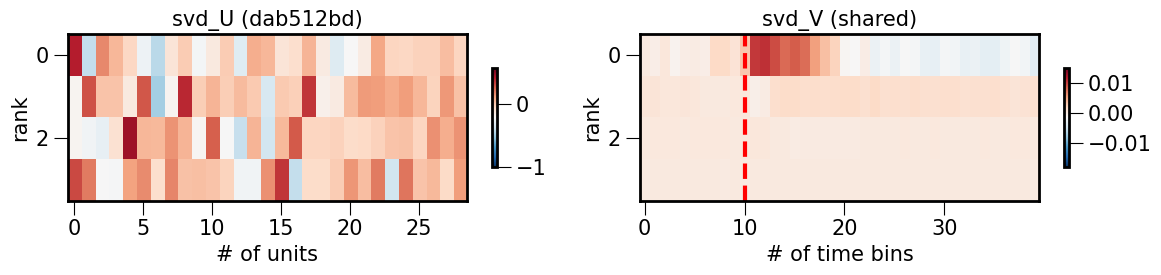

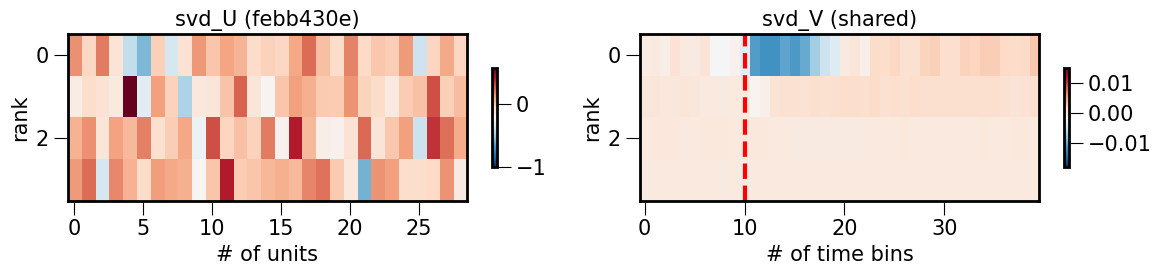

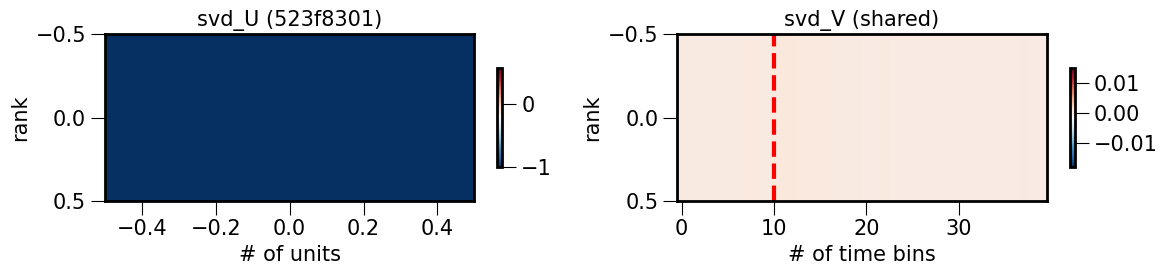

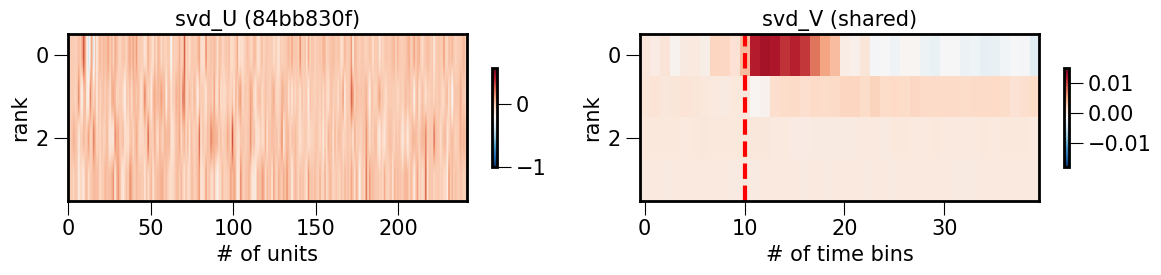

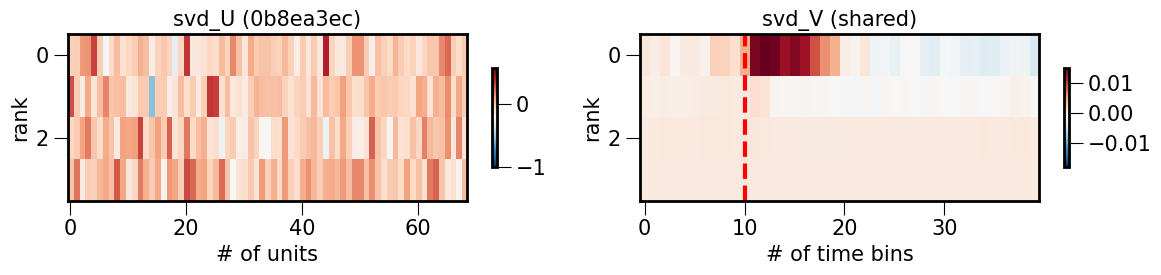

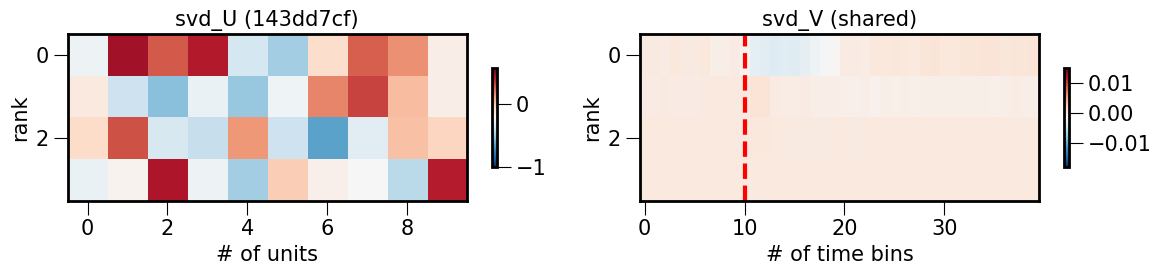

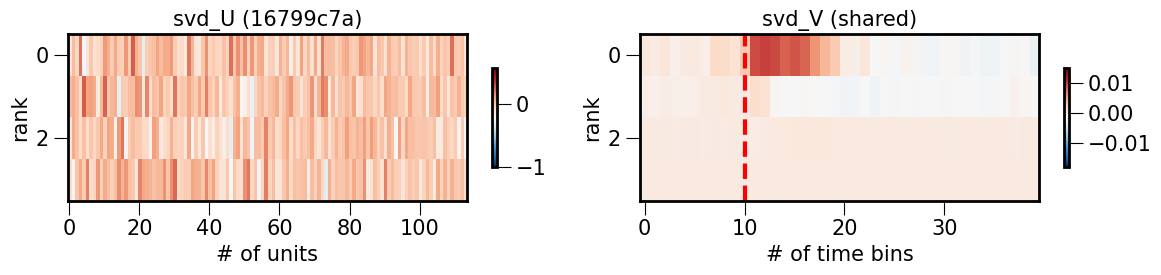

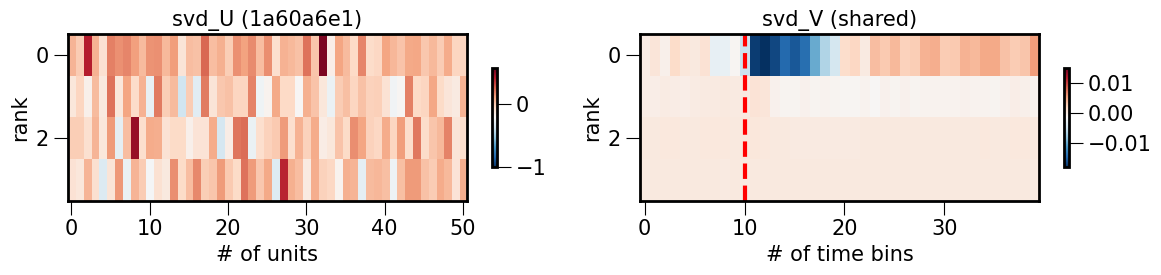

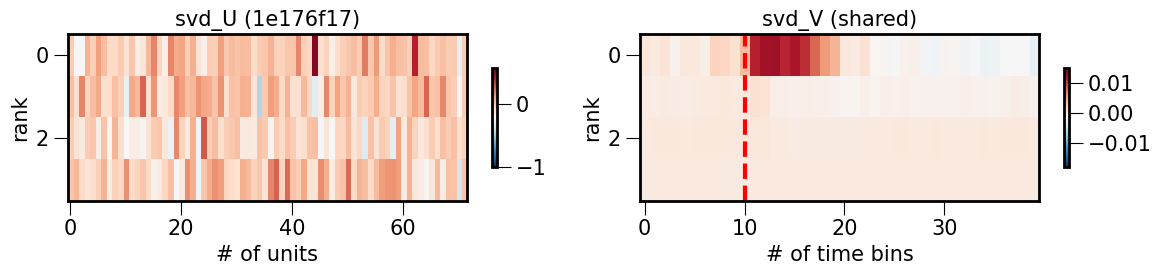

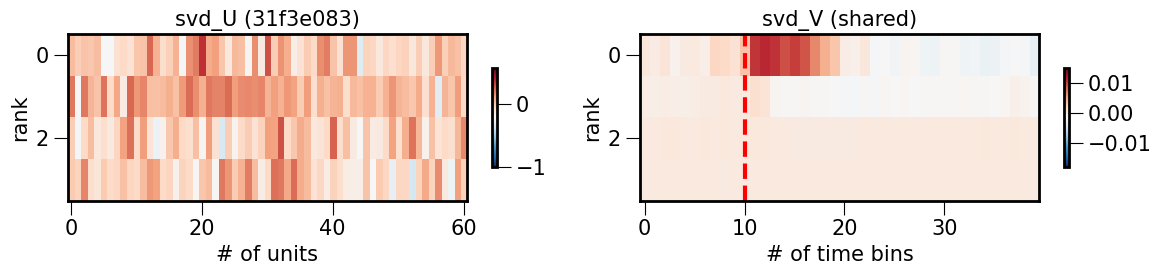

In [ ]:
svd_W, svd_U, svd_S, svd_VT, S_mul_VT, W_reduced = [], [], [], [], [], []

for pid in pids:
    # average U and V across trials
    W = np.array(Us[pid]).mean(0) @ np.array(Vs[pid]).mean(0).squeeze()
    U, S, VT = svd(W)
    svd_W.append(W)
    svd_U.append(U[:, :rank])
    svd_S.append(S[:rank])
    svd_VT.append(VT[:rank, :])
    # W_low_rank = np.dot(np.dot(U[:, :R],np.diag(S[:R])),VT[:R, :])
    # W_reduced.append(W_low_rank)
    if len(S) == 1:
        S_mul_VT.append(np.diag(S) @ VT[:1, :])
    else:
        S_mul_VT.append(np.diag(S[:rank]) @ VT[:rank, :])
    
    
u_min, u_max = np.min([arr.min() for arr in svd_U]), np.max([arr.max() for arr in svd_U])
v_min, v_max = np.min([arr.min() for arr in S_mul_VT]), np.max([arr.max() for arr in S_mul_VT])
c_min, c_max = np.min([u_min, v_min]), np.max([u_max, v_max])
    
for pid_idx, pid in enumerate(pids):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 3))
    heatmap1 = ax1.imshow(svd_U[pid_idx].T, aspect="auto", cmap="RdBu_r", vmin=u_min, vmax=u_max)
    heatmap2 = ax2.imshow(S_mul_VT[pid_idx], aspect="auto", cmap="RdBu_r", vmin=v_min, vmax=v_max)
    ax2.axvline(x=10, c="red", linestyle="--", linewidth=3)
    cbar = fig.colorbar(heatmap1, ax=ax1, shrink=0.6)
    cbar = fig.colorbar(heatmap2, ax=ax2, shrink=0.6)
    ax1.set_ylabel("rank")
    ax1.set_xlabel("# of units")
    ax1.set_title(f"svd_U ({pid[:8]})")
    ax2.set_ylabel("rank")
    ax2.set_xlabel("# of time bins")
    ax2.set_title(f"svd_V (shared)")
    plt.tight_layout()

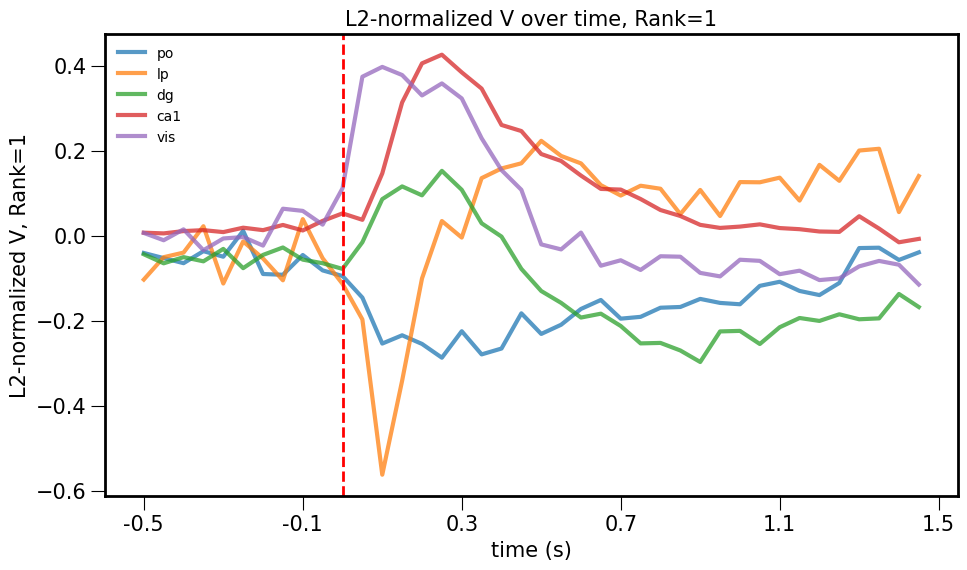

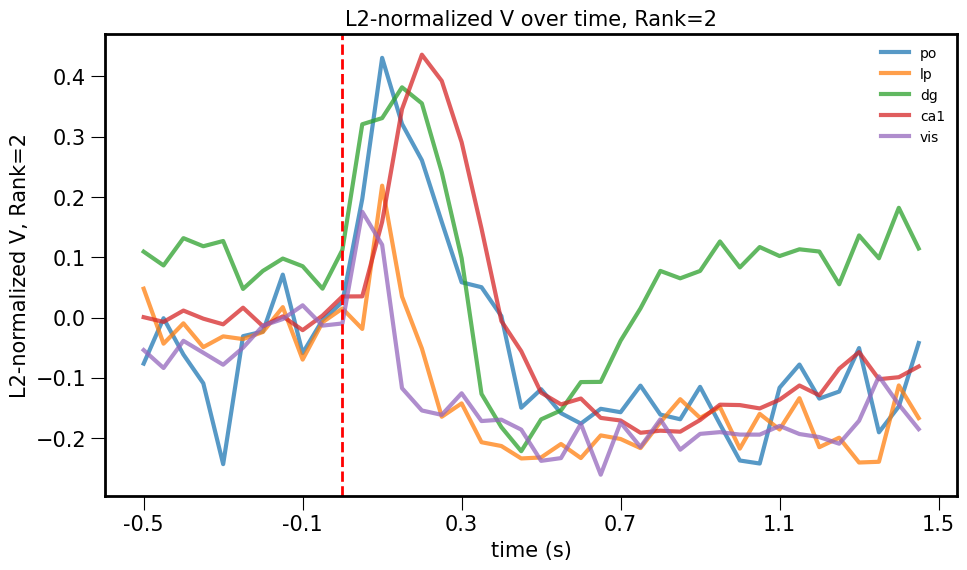

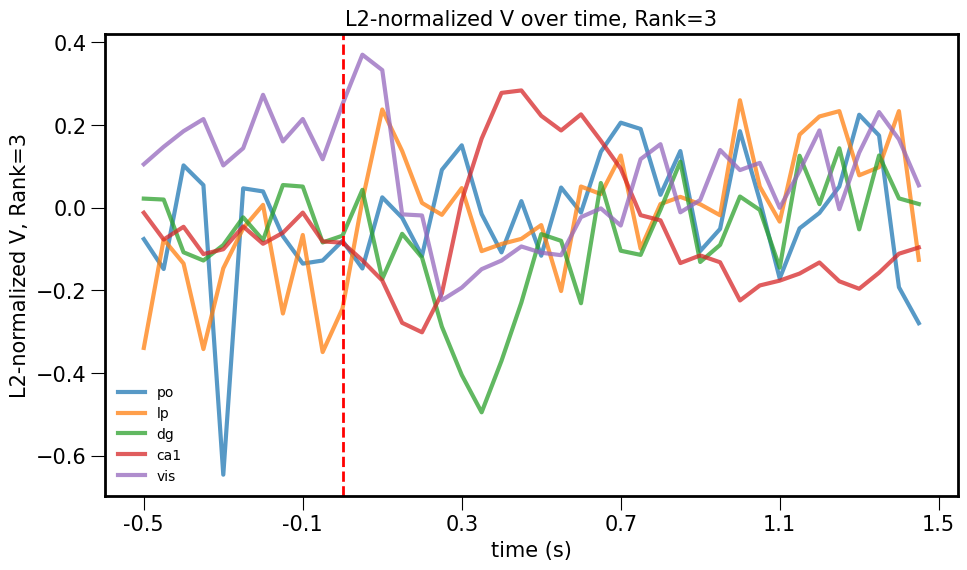

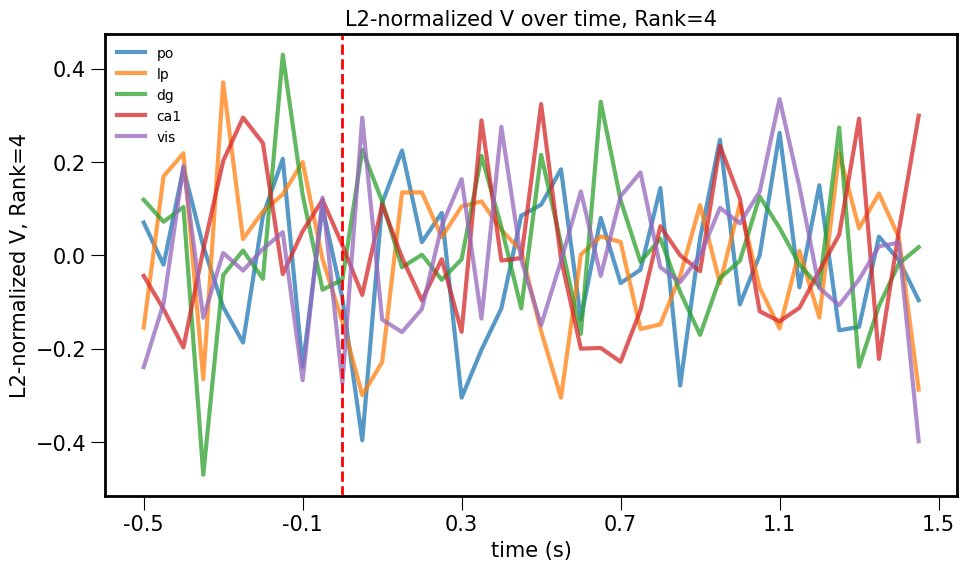

In [ ]:
def get_avg_norm_svd_V(V):
    V = np.mean(V, axis=1)
    V = V * (1 / np.linalg.norm(V, axis=2))[:, :, None]
    return V

def plot_normalized_v(norm_V, plot_rank=0):
    norm_V = norm_V[:, plot_rank, :]
    plt.figure(figsize=(11,6))

    for i in range(norm_V.shape[0]):
        plt.plot(norm_V[i], label=regions[i], linewidth=3, alpha=.75)

    plt.axvline(x=10, c="red", linestyle="--", linewidth=2)
    plt.xticks(np.linspace(0, 40, 6), np.round(np.linspace(-0.5, 1.5, 6), decimals=3))
    plt.xlabel("time (s)")
    plt.ylabel(f"L2-normalized V, Rank={plot_rank+1}")
    # Add a title
    plt.title(f"L2-normalized V over time, Rank={plot_rank+1}")
    plt.legend(frameon=False)

    # filename = f"./figures/plot_{pid_idx+1}.png"
    plt.savefig(f"./figures/l2_norm_rank_over_time{plot_rank+1}.png", dpi=100)
    plt.show()
    

norm_svd_V = get_avg_norm_svd_V(all_svd_V)
for i in range(rank):
    plot_normalized_v(norm_svd_V, plot_rank=i)